# RIDC-AB

RIDC scheme with AB(4) as predictor and AB(2) as corrector. Startup values on prediction level are generated using RK4 on prediction layer and RK2 on corrrection layers.

In [1]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# import threading
import time
import numpy as np
from scipy.interpolate import lagrange

In [2]:
# Higher order RIDC-AB implementation
def RIDC_Solver_AB(ff, T, y0, N, M, K): # Definitely functions without error for K >= 2M
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M:  number of correction loops
    K:  length of grouped intervals for RIDC method, K > M

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    # define the nested functions
    def corrector_RK2(Y2, Y2l, Y2lmp, Y1vec, TVal, Tvec, Sm): # RK2
        quad_approx = sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        k1 = ff(TVal, Y2) - ff(TVal, Y2l)
        k2 = ff(TVal+h, Y2 + h*(k1 + quad_approx)) - ff(TVal+h, Y2lmp)
        Y2plus = Y2+h*((k1+k2)/2 + quad_approx)
        return Y2plus
    
    def corrector_AB2(Y2s, Y1s, Y1vec, Tvals, Tvec, Sm): # AB(2)
        Y2plus = Y2s[:, -1] + h*3*(ff(Tvals[-1], Y2s[:, -1])-ff(Tvals[-1], Y1s[:, -1]))/2 - \
            h*(ff(Tvals[-2], Y2s[:, -2])-ff(Tvals[-2], Y1s[:, -2]))/2 + \
            h*sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Y2plus
    
    def predictor_RK4(Ypred, Tpred): # RK4
        k1 = ff(Tpred, Ypred)
        k2 = ff(Tpred + h/2, Ypred + h*k1/2)
        k3 = ff(Tpred + h/2, Ypred + h*k2/2)
        k4 = ff(Tpred + h, Ypred + h*k3)
        return Ypred + h*(k1 + 2*k2 + 2*k3 + k4)/6
    
    def predictor_AB4(Ypreds, Tpreds): # AB(4)
        return Ypreds[:, -1]+h*(55*ff(Tpreds[-1], Ypreds[:, -1]) - 59*ff(Tpreds[-2], Ypreds[:, -2]) + \
                             37*ff(Tpreds[-3], Ypreds[:, -3]) - 9*ff(Tpreds[-4], Ypreds[:, -4]))/24
    
    # number of invervals in each group
    if N % K != 0:
        raise "K must divide N evenly"
    J = int(N/K)
    # time step
    h = float(T)/N
    # Forming the quadraure matrix S[m,i]
    # number of equations in ODE (aka degree of freedom, dimension of space)
    d = len(y0)
    S = np.zeros([M, M+1])
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[M-1, :]
    # storing the final answer in yy
    yy = np.zeros([d, N+1])
    # the time vector
    t = np.arange(0, T+h, h)
    t_ext = np.arange(0, T+h+M*h, h)
    # putting the initial condition in y
    yy[:, 0] = y0
    for j in range(J):   # loop over each group of intervals j
        
        # print(j) - ENABLE FOR TESTING!!!
        
        # ----------------------------------------------------------------------
        # Phase 1: compute to the point every threads can start simultaneously
        #print("Phase 1")
        Ybegin = np.zeros([d, M+1, 2*M])
        # predictor starts w last point in j-1 interval
        Ybegin[:, 0, 0] = yy[:, j*K]
        # predictor loop using forward Euler method
        for m in range(2*M-1):
            t[j*K+m+1] = (j*K+m+1) * h
            if m < 3:
                Ybegin[:, 0, m+1] = predictor_RK4(Ybegin[:, 0, m], t[j*K+m])
            else:
                Ybegin[:, 0, m+1] = predictor_AB4(Ybegin[:, 0, m-3:m+1], t[j*K+m-3:j*K+m+1])
        # corrector loops using Lagrange polynomials
        for l in range(1, M+1):
            Ybegin[:, l, :] = np.zeros([d, 2*M])
            Ybegin[:, l, 0] = yy[:, j*K]
            for m in range(M):
                if m == 0:
                    # Apply RK2
                    Ybegin[:, l, m+1] = corrector_RK2(Ybegin[:, l, m], 
                                                      Ybegin[:, l-1, m], 
                                                      Ybegin[:, l-1, m+1],
                                                      Ybegin[:, l-1, 0:M+1], 
                                                      t[j*K+m], 
                                                      t[j*K:j*K+M+1], 
                                                      S[m, :])
                else:
                    # Apply AB(2), corrector_AB2(Y2s, Y1s, Y1vec, Tvals, Tvec, Sm)
                    Ybegin[:, l, m+1] = corrector_AB2(Ybegin[:, l, m-1:m+1], 
                                                      Ybegin[:, l-1, m-1:m+1], 
                                                      Ybegin[:, l-1, 0:M+1], 
                                                      t[j*K+m-1:j*K+m+1], 
                                                      t[j*K:j*K+M+1], 
                                                      S[m, :])
                    
            for m in range(M, 2*M-l):
                # Apply AB(2)
                Ybegin[:, l, m+1] = corrector_AB2(Ybegin[:, l, m-1:m+1], 
                                                  Ybegin[:, l-1, m-1:m+1], 
                                                  Ybegin[:, l-1, m-M+1:m-M+1+M+1], 
                                                  t[j*K+m-1:j*K+m+1], 
                                                  t[j*K+m-M+1:j*K+m-M+1+M+1], 
                                                  Svec)
                
        Ypreds = Ybegin[:, 0, -4:]
        yy[:, j*K:j*K+M] = Ybegin[:, M, 0:M]
        # declare and fill up Y1corr and Y2corr for phase two
        Y1corr = np.zeros([d, M, M+1])
        Y2corr = np.zeros([d, M, 2])
        for l in range(1, M+1):
            # 'lm' is for corrector 'l' (trying to save space for Y1corr&Y2corr)
            lm = l - 1
            Y1corr[:, lm, :] = Ybegin[:, l-1, M-l:2*M-l+1]
            Y2corr[:, lm, :] = Ybegin[:, l, 2*M-l-2:2*M-l]
        # ----------------------------------------------------------------------
        # Phase 2: all threads can go simultaneously now
        #print("Phase 2")
        for m in range(M-1, K):
            # predictor
            Tpreds = t_ext[j*K+m+M-3:j*K+m+M+1]
            Ypred = predictor_AB4(Ypreds, Tpreds)
            # Shuffle the previous predictions back
            for i in range(1, 4):
                Ypreds[:, i-1] = Ypreds[:, i]
            Ypreds[:, -1] = Ypred
            # correctors
            for l in range(1, M+1):
                lm = l - 1
                Tvec = t_ext[j*K+m-l+1:j*K+m-l+1+M+1]
                # Apply AB(4)
                Y2corrVal = corrector_AB2(Y2corr[:, lm, :], 
                                          Y1corr[:, lm, -3:-1], 
                                          Y1corr[:, lm, :], 
                                          Tvec[-3:-1], 
                                          Tvec, 
                                          Svec)
                Y2corr[:, lm, 0] = Y2corr[:, lm, 1]
                Y2corr[:, lm, 1] = Y2corrVal
            # update the stencil
            Y1corr[:, 0, 0:M] = Y1corr[:, 0, 1:M+1]
            Y1corr[:, 0, M] = Ypred
            for lm in range(1, M):
                Y1corr[:, lm, 0:M] = Y1corr[:, lm, 1:M+1]
                Y1corr[:, lm, M] = Y2corr[:, lm-1, 1]
            # put the most corrected point in the final answer
            yy[:, j*K+m+1] = Y2corr[:, M-1, 1]
    return t, yy

In [3]:
# Dalhquist test equation for lambda = 1
func_dahl = lambda t, y: y
exact_dahl = lambda t: np.exp(t)

# Scalar IVP
func_tsqrty = lambda t, y: 4*t*np.sqrt(y)
exact_tsqrty = lambda t: (1+t**2)**2

# Planar IVP
def func_sincos(t, y):
    y1 = y[0]
    y2 = y[1]
    y1_p = y2 - y1*(1-y1**2-y2**2)
    y2_p = -y1 + y2*(1-y1**2-y2**2)
    return np.array([y1_p, y2_p])

def exact_sincos(t):
    return np.array([np.sin(t), np.cos(t)])

# Returns time points vector for graphing
def get_tvec(T, N):
    h = float(T)/N
    return np.array([h*n for n in range(N+1)])

# Returns inf norm of a vector of exact and approx solution differences
def get_infnorm(approx, exact):
    D = exact.ndim
    if D == 1:
        return np.linalg.norm(approx-exact, np.inf)
    else:
        return max([np.linalg.norm(approx[i]-exact[i], np.inf) for i in range(len(exact))])

---

## Convergence Tests

Graph and tables showing order of convergence for scalar IVP, using $M = 3, 4, 5$.

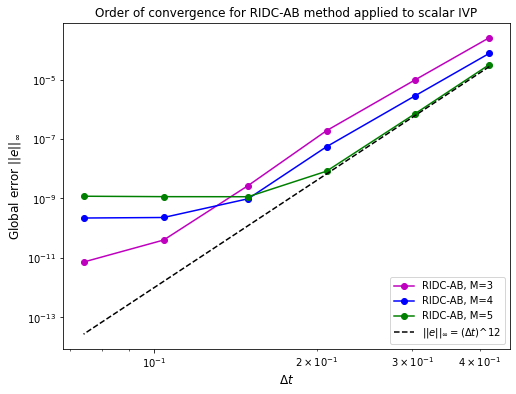

In [7]:
# Setting up parameters - note that we use K = N/2
T = 10.0
y0 = np.array([1.0])
# K = 8

# List of number of intervals
# We can broaden the range of test values before hitting machine precision by indexing in powers of sqrt(2)
Ns = [int(24*np.sqrt(2)**i) for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when IDC is applied to scalar problem
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(3,6):
    usedNs = []
    for n_ in Ns:
        n = n_
        while n % 2 != 0:
            n += 1
        usedNs.append(n)
    RIDC_error_m = [get_infnorm(RIDC_Solver_AB(func_tsqrty, T, y0, n, m, int(n/2))[1][0], 
                                exact_tsqrty(get_tvec(T, n))) for n in usedNs]
    plt.plot(delts, RIDC_error_m, cols[m-3]+'o-', label=f'RIDC-AB, M={m}')

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,6)
#plt.rc('font', size=10)
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
plt.plot(delts, [d**12 for d in delts], 'k--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{12}')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for RIDC-AB method applied to scalar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

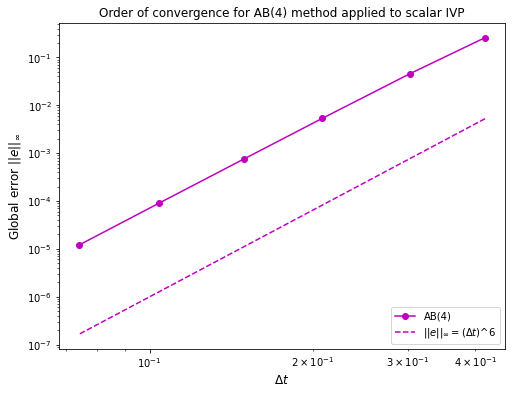

In [9]:
def AB4_InitRK4(f, T, y0, N):
    '''
    Inputs:
    f:  the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0123: initial condition (first four y values are needed)
    N:  number of time intervals

    Output:
    y:  as function of time
    '''
    
    # time step
    h = float(T)/N
    
    # time points vector
    t = np.arange(0, T+h, h)
    
    # output vector
    d = len(y0)
    y = np.zeros([d,N+1])
    
    # setting initial conditions (next three points)
    y[:, 0] = y0
    
    # Get next three points using RK4
    for i in range(0, 3):
        y1 = f(t[i], y[:, i])
        y2 = f(t[i]+h/2, y[:, i]+h*y1/2)
        y3 = f(t[i]+h/2, y[:, i]+h*y2/2)
        y4 = f(t[i]+h, y[:, i]+h*y3)
        y[:, i+1] = y[:, i] + h*(y1 + 2*y2 + 2*y3 + y4)/6
    
    # AB-4 method
    for i in range(3, N):
        y[:,i+1] = y[:,i] + h*(55*f(t[i],y[:,i]) - 59*f(t[i-1],y[:,i-1]) + 37*f(t[i-2],y[:,i-2]) - 9*f(t[i-3],y[:,i-3]))/24
    
    return y, h, t

# AB4 output for comparison
y_approx_AB4_mod = [get_infnorm(AB4_InitRK4(func_tsqrty, T, y0, n)[0][0], 
                                exact_tsqrty(get_tvec(T, n))) for n in Ns]

# Plotting results
plt.plot(delts, y_approx_AB4_mod, cols[0]+'o-', label=f'AB(4)')
plt.plot(delts, [d**6 for d in delts], cols[0]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{6}')
#plt.plot(delts, [d**12 for d in delts], 'k--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{12}')
plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for AB(4) method applied to scalar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

In [12]:
import pandas as pd

# Setting up parameters - note that we use K = N/2
T = 10.0
y0 = np.array([1.0])
# K = 8

# List of number of intervals
# We can broaden the range of test values before hitting machine precision by indexing in powers of sqrt(2)
Ns = [int(24*np.sqrt(2)**i) for i in np.arange(6)]

# List of tables for each M value 
RIDC_M_tables = []

for m in range(3,6):
    usedNs = []
    for n_ in Ns:
        n = n_
        while n % 2 != 0:
            n += 1
        usedNs.append(n)
    
    RIDC_error_m = [get_infnorm(RIDC_Solver_AB(func_tsqrty, T, y0, n, m, int(n/2))[1][0], 
                                exact_tsqrty(get_tvec(T, n))) for n in usedNs]
    m_table = []
    for i, err in enumerate(RIDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            m_table.append((r'$\Delta t$/'+f'{np.round(np.sqrt(2)**i,2)}', err, np.round(2*np.log2(RIDC_error_m[i-1]/err), 3)))
            
    RIDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to {T}/{Ns[0]}...')
for i, table in enumerate(RIDC_M_tables):
    print(f'RIDC-AB method with M = {i+3}:')
    display(table)
    print()

For step size equal to 10.0/24...
RIDC-AB method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,2.560890e-04,n/a
1,$\Delta t$/1.41,9.519157e-06,9.499
2,$\Delta t$/2.0,1.903591e-07,11.288
3,$\Delta t$/2.83,2.719389e-09,12.259
4,$\Delta t$/4.0,4.001777e-11,12.173
5,$\Delta t$/5.66,7.275958e-12,4.919



RIDC-AB method with M = 4:


,Step Size,Max Error,Order
0,$\Delta t$,7.623733e-05,n/a
1,$\Delta t$/1.41,2.774319e-06,9.561
2,$\Delta t$/2.0,5.498077e-08,11.314
3,$\Delta t$/2.83,9.786163e-10,11.624
4,$\Delta t$/4.0,2.291927e-10,4.188
5,$\Delta t$/5.66,2.200977e-10,0.117



RIDC-AB method with M = 5:


,Step Size,Max Error,Order
0,$\Delta t$,3.187013e-05,n/a
1,$\Delta t$/1.41,6.923838e-07,11.049
2,$\Delta t$/2.0,8.276402e-09,12.773
3,$\Delta t$/2.83,1.144144e-09,5.709
4,$\Delta t$/4.0,1.151420e-09,-0.018
5,$\Delta t$/5.66,1.189619e-09,-0.094


---

Graph and tables showing order of convergence for planar IVP, using $M = 3, 4, 5$.

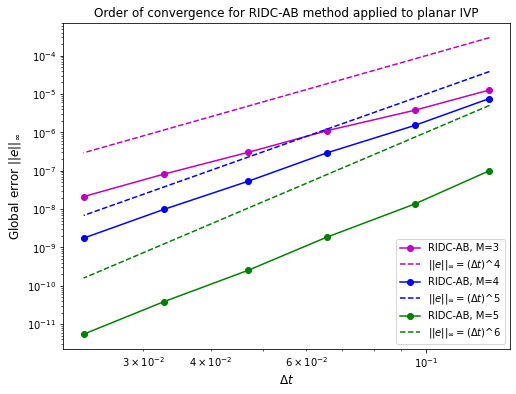

In [11]:
# Setting up parameters - note that we use K = N/2
T = np.pi
y0 = np.array([0.0, 1.0])
# K = 8

# List of number of intervals
# We can broaden the range of test values before hitting machine precision by indexing in powers of sqrt(2)
Ns = [int(24*np.sqrt(2)**i) for i in np.arange(6)]

# Delta t values (step sizes)
delts = [T/n for n in Ns]

# Error vector inf norms for each step size when IDC is applied to scalar problem
cols = ['m', 'b', 'g', 'r', 'y', 'k', 'c']
for m in range(3,6):
    usedNs = []
    for n_ in Ns:
        n = n_
        while n % 2 != 0:
            n += 1
        usedNs.append(n)
    
    RIDC_error_m = [get_infnorm(RIDC_Solver_AB(func_sincos, T, y0, n, m, int(n/2))[1], 
                                exact_sincos(get_tvec(T, n))) for n in usedNs]
    plt.plot(delts, RIDC_error_m, cols[m-3]+'o-', label=f'RIDC-AB, M={m}')
    plt.plot(delts, [d**(m+1) for d in delts], cols[m-3]+'--', label=r'$\|\|e\|\|_{\infty} = (\Delta t)$'+f'^{m+1}')


plt.xscale('log')
plt.yscale('log')
plt.title(r'Order of convergence for RIDC-AB method applied to planar IVP')
plt.xlabel(r'$\Delta t$')
plt.ylabel(r'Global error $\|\|e\|\|_{\infty}$')
#plt.grid()
plt.legend(loc='lower right')
plt.show()

In [13]:
# Setting up parameters - note that we use K = N/2
T = np.pi
y0 = np.array([0.0, 1.0])
# K = 8

# List of number of intervals
# We can broaden the range of test values before hitting machine precision by indexing in powers of sqrt(2)
Ns = [int(24*np.sqrt(2)**i) for i in np.arange(6)]

# List of tables for each M value 
RIDC_M_tables = []

for m in range(3,6):
    usedNs = []
    for n_ in Ns:
        n = n_
        while n % 2 != 0:
            n += 1
        usedNs.append(n)
        
    RIDC_error_m = [get_infnorm(RIDC_Solver_AB(func_sincos, T, y0, n, m, int(n/2))[1], 
                                exact_sincos(get_tvec(T, n))) for n in usedNs]
    m_table = []
    for i, err in enumerate(RIDC_error_m):
        if i == 0:
            m_table.append((r'$\Delta t$', err, "n/a"))
        else:
            m_table.append((r'$\Delta t$/'+f'{np.round(np.sqrt(2)**i,2)}', err, np.round(2*np.log2(RIDC_error_m[i-1]/err), 3)))
            
    RIDC_M_tables.append(pd.DataFrame(m_table, columns=['Step Size', 'Max Error', 'Order']))
            
# Display results
print(f'For step size equal to pi/{Ns[0]}...')
for i, table in enumerate(RIDC_M_tables):
    print(f'RIDC-AB method with M = {i+3}:')
    display(table)
    print()

For step size equal to pi/24...
RIDC-AB method with M = 3:


,Step Size,Max Error,Order
0,$\Delta t$,1.272412e-05,n/a
1,$\Delta t$/1.41,3.759347e-06,3.518
2,$\Delta t$/2.0,1.098153e-06,3.551
3,$\Delta t$/2.83,3.015641e-07,3.729
4,$\Delta t$/4.0,8.125927e-08,3.784
5,$\Delta t$/5.66,2.115291e-08,3.883



RIDC-AB method with M = 4:


,Step Size,Max Error,Order
0,$\Delta t$,7.614847e-06,n/a
1,$\Delta t$/1.41,1.512477e-06,4.664
2,$\Delta t$/2.0,2.899154e-07,4.766
3,$\Delta t$/2.83,5.320082e-08,4.892
4,$\Delta t$/4.0,9.780426e-09,4.887
5,$\Delta t$/5.66,1.750203e-09,4.965



RIDC-AB method with M = 5:


,Step Size,Max Error,Order
0,$\Delta t$,1.000803e-07,n/a
1,$\Delta t$/1.41,1.353076e-08,5.774
2,$\Delta t$/2.0,1.841197e-09,5.755
3,$\Delta t$/2.83,2.541827e-10,5.713
4,$\Delta t$/4.0,3.842292e-11,5.452
5,$\Delta t$/5.66,5.483439e-12,5.618


---

## Stability Regions

In [12]:
# Dalhquist test equation for lambda
lam = complex(0, 0)
func_dahl_lam = lambda t, y: lam*y
exact_dahl_lam = lambda t: np.exp(lam*t)

In [13]:
def RK4_complex(f, T, y0, N):
    '''
    Inputs:
    f:  the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of time intervals

    Output:
    y:  as function of time
    '''
    
    # time step
    h = float(T)/N
    
    # time points vector
    t = np.arange(0, T+h, h)
    
    # output vector
    y = np.zeros(N+1, dtype=complex)
    
    # setting initial condition
    y[0] = y0
    
    # RK4 method
    for i in range(N):
        y1 = f(t[i], y[i])
        y2 = f(t[i]+h/2, y[i]+h*y1/2)
        y3 = f(t[i]+h/2, y[i]+h*y2/2)
        y4 = f(t[i]+h, y[i]+h*y3)
        y[i+1] = y[i] + h*(y1 + 2*y2 + 2*y3 + y4)/6
    
    return y, h, t

In [14]:
def AB4_complex(f, T, y0123, N):
    '''
    Inputs:
    f:  the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0123: initial condition (first four y values are needed)
    N:  number of time intervals

    Output:
    y:  as function of time
    '''
    
    # time step
    h = float(T)/N
    
    # time points vector
    t = np.arange(0, T+h, h)
    
    # output vector
    y = np.zeros(N+1, dtype=complex)
    
    # setting initial conditions (first four points)
    y[0:4] = y0123
    
    # AB-4 method
    for i in range(3, N):
        y[i+1] = y[i] + h*(55*f(t[i],y[i]) - 59*f(t[i-1],y[i-1]) + 37*f(t[i-2],y[i-2]) - 9*f(t[i-3],y[i-3]))/24
    
    return y, h, t

In [15]:
def RIDC_Solver_AB_complex(ff, T, y0, N, M, K):
    '''
    Inputs:
    ff: the RHS of the system of ODEs y'=f(t,y)
    T:  integration interval[0,T]
    y0: initial condition
    N:  number of nodes
    M:  number of correction loops
    K:  length of grouped intervals for RIDC method, K > M

    Output:
    t: array of time points
    yy: approximations at the given time points
    '''
    # define the nested functions
    def corrector_RK2(Y2, Y2l, Y2lmp, Y1vec, TVal, Tvec, Sm): # RK2
        quad_approx = sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        k1 = ff(TVal, Y2) - ff(TVal, Y2l)
        k2 = ff(TVal+h, Y2 + h*(k1 + quad_approx)) - ff(TVal+h, Y2lmp)
        Y2plus = Y2+h*((k1+k2)/2 + quad_approx)
        return Y2plus
    
    def corrector_AB2(Y2s, Y1s, Y1vec, Tvals, Tvec, Sm): # AB(2)
        Y2plus = Y2s[:, -1] + h*3*(ff(Tvals[-1], Y2s[:, -1])-ff(Tvals[-1], Y1s[:, -1]))/2 - \
            h*(ff(Tvals[-2], Y2s[:, -2])-ff(Tvals[-2], Y1s[:, -2]))/2 + \
            h*sum([Sm[i]*ff(Tvec[i], Y1vec[:, i]) for i in range(M+1)])
        return Y2plus
    
    def predictor_RK4(Ypred, Tpred): # RK4
        k1 = ff(Tpred, Ypred)
        k2 = ff(Tpred + h/2, Ypred + h*k1/2)
        k3 = ff(Tpred + h/2, Ypred + h*k2/2)
        k4 = ff(Tpred + h, Ypred + h*k3)
        return Ypred + h*(k1 + 2*k2 + 2*k3 + k4)/6
    
    def predictor_AB4(Ypreds, Tpreds): # AB(4)
        return Ypreds[:, -1]+h*(55*ff(Tpreds[-1], Ypreds[:, -1]) - 59*ff(Tpreds[-2], Ypreds[:, -2]) + \
                             37*ff(Tpreds[-3], Ypreds[:, -3]) - 9*ff(Tpreds[-4], Ypreds[:, -4]))/24
    
    # number of invervals in each group
    if N % K != 0:
        raise "K must divide N evenly"
    J = int(N/K)
    # time step
    h = float(T)/N
    # Forming the quadraure matrix S[m,i]
    # number of equations in ODE (aka degree of freedom, dimension of space)
    d = len(y0)
    S = np.zeros([M, M+1], dtype=complex)
    for m in range(M):  # Calculate qudrature weights
        for i in range(M+1):
            x = np.arange(M+1)  # Construct a polynomial
            y = np.zeros(M+1)   # which equals to 1 at i, 0 at other points
            y[i] = 1
            p = lagrange(x, y)
            para = np.array(p)    # Compute its integral
            P = np.zeros(M+2)
            for k in range(M+1):
                P[k] = para[k]/(M+1-k)
            P = np.poly1d(P)
            S[m, i] = P(m+1) - P(m)
    Svec = S[M-1, :]
    # storing the final answer in yy
    yy = np.zeros([d, N+1], dtype=complex)
    # the time vector
    t = np.arange(0, T+h, h)
    t_ext = np.arange(0, T+h+M*h, h)
    # putting the initial condition in y
    yy[:, 0] = y0
    for j in range(J):   # loop over each group of intervals j
        
        # print(j) - ENABLE FOR TESTING!!!
        
        # ----------------------------------------------------------------------
        # Phase 1: compute to the point every threads can start simultaneously
        #print("Phase 1")
        Ybegin = np.zeros([d, M+1, 2*M], dtype=complex)
        # predictor starts w last point in j-1 interval
        Ybegin[:, 0, 0] = yy[:, j*K]
        # predictor loop using forward Euler method
        for m in range(2*M-1):
            t[j*K+m+1] = (j*K+m+1) * h
            if m < 3:
                Ybegin[:, 0, m+1] = predictor_RK4(Ybegin[:, 0, m], t[j*K+m])
            else:
                Ybegin[:, 0, m+1] = predictor_AB4(Ybegin[:, 0, m-3:m+1], t[j*K+m-3:j*K+m+1])
        # corrector loops using Lagrange polynomials
        for l in range(1, M+1):
            Ybegin[:, l, :] = np.zeros([d, 2*M], dtype=complex)
            Ybegin[:, l, 0] = yy[:, j*K]
            for m in range(M):
                if m == 0:
                    # Apply RK2
                    Ybegin[:, l, m+1] = corrector_RK2(Ybegin[:, l, m], 
                                                      Ybegin[:, l-1, m], 
                                                      Ybegin[:, l-1, m+1],
                                                      Ybegin[:, l-1, 0:M+1], 
                                                      t[j*K+m], 
                                                      t[j*K:j*K+M+1], 
                                                      S[m, :])
                else:
                    # Apply AB(2), corrector_AB2(Y2s, Y1s, Y1vec, Tvals, Tvec, Sm)
                    Ybegin[:, l, m+1] = corrector_AB2(Ybegin[:, l, m-1:m+1], 
                                                      Ybegin[:, l-1, m-1:m+1], 
                                                      Ybegin[:, l-1, 0:M+1], 
                                                      t[j*K+m-1:j*K+m+1], 
                                                      t[j*K:j*K+M+1], 
                                                      S[m, :])
                    
            for m in range(M, 2*M-l):
                # Apply AB(2)
                Ybegin[:, l, m+1] = corrector_AB2(Ybegin[:, l, m-1:m+1], 
                                                  Ybegin[:, l-1, m-1:m+1], 
                                                  Ybegin[:, l-1, m-M+1:m-M+1+M+1], 
                                                  t[j*K+m-1:j*K+m+1], 
                                                  t[j*K+m-M+1:j*K+m-M+1+M+1], 
                                                  Svec)
                
        Ypreds = Ybegin[:, 0, -4:]
        yy[:, j*K:j*K+M] = Ybegin[:, M, 0:M]
        # declare and fill up Y1corr and Y2corr for phase two
        Y1corr = np.zeros([d, M, M+1], dtype=complex)
        Y2corr = np.zeros([d, M, 2], dtype=complex)
        for l in range(1, M+1):
            # 'lm' is for corrector 'l' (trying to save space for Y1corr&Y2corr)
            lm = l - 1
            Y1corr[:, lm, :] = Ybegin[:, l-1, M-l:2*M-l+1]
            Y2corr[:, lm, :] = Ybegin[:, l, 2*M-l-2:2*M-l]
        # ----------------------------------------------------------------------
        # Phase 2: all threads can go simultaneously now
        #print("Phase 2")
        for m in range(M-1, K):
            # predictor
            Tpreds = t_ext[j*K+m+M-3:j*K+m+M+1]
            Ypred = predictor_AB4(Ypreds, Tpreds)
            # Shuffle the previous predictions back
            for i in range(1, 4):
                Ypreds[:, i-1] = Ypreds[:, i]
            Ypreds[:, -1] = Ypred
            # correctors
            for l in range(1, M+1):
                lm = l - 1
                Tvec = t_ext[j*K+m-l+1:j*K+m-l+1+M+1]
                # Apply AB(4)
                Y2corrVal = corrector_AB2(Y2corr[:, lm, :], 
                                          Y1corr[:, lm, -3:-1], 
                                          Y1corr[:, lm, :], 
                                          Tvec[-3:-1], 
                                          Tvec, 
                                          Svec)
                Y2corr[:, lm, 0] = Y2corr[:, lm, 1]
                Y2corr[:, lm, 1] = Y2corrVal
            # update the stencil
            Y1corr[:, 0, 0:M] = Y1corr[:, 0, 1:M+1]
            Y1corr[:, 0, M] = Ypred
            for lm in range(1, M):
                Y1corr[:, lm, 0:M] = Y1corr[:, lm, 1:M+1]
                Y1corr[:, lm, M] = Y2corr[:, lm-1, 1]
            # put the most corrected point in the final answer
            yy[:, j*K+m+1] = Y2corr[:, M-1, 1]
    return t, yy

In [16]:
# final time
T = 60
# number of intervals
N = 60
# initial condition y(0) = y0
y0 = np.array([complex(1, 0)])
# new centre at (-0.1, 0)
cen = complex(-0.1, 0)

# Setting up parameters
thetas = np.linspace(0, 2*np.pi, 121)
INC = 8
base = 2**(-INC)
eps = 1

# Setting up additional parameters for RIDC-AB
M = 3
Ks = [10, 15, 20, 30, 60]

RIDC_K_bound = []

for k in Ks:
    print(f"K = {k}")
    K_bound = []
    for theta in thetas:
        Aact = 0
        Acurr = 1
        count = 0
        searching = True
        
        while searching:
            Acurr = base*2**count
            if Acurr > 4:
                break
            A = Aact + Acurr
            lam = complex(A*np.cos(theta), A*np.sin(theta)) + cen
            last_val = RIDC_Solver_AB_complex(func_dahl_lam, T, y0, N, M, k)[1][:, -1]
            inf_norm = np.abs(last_val)
            
            if inf_norm > eps:
                count = 0
                if Acurr > base:
                    Aact += Acurr/2
                else:
                    searching = False
            else:
                count += 1
        
        
        if Acurr <= 4:
            K_bound.append([lam.real, lam.imag])
            
    RIDC_K_bound.append(np.array(K_bound))

print("Done!")

K = 10
K = 15
K = 20
K = 30
K = 60
Done!


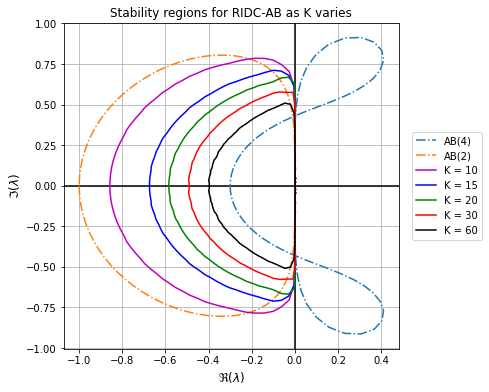

In [20]:
# ...
cols = ['m', 'b', 'g', 'r', 'k', 'tab:gray', 'c', 'p-', 'h-']

plt.figure(figsize = (6, 6))
plt.rc('axes', titlesize=12)
plt.rc('axes', labelsize=12)
plt.rc('legend', fontsize=10)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')

thetas_ = np.linspace(-np.pi, np.pi, 81)
exps = [complex(np.cos(t), np.sin(t)) for t in thetas_]

# AB(4) stability region
rho4 = lambda c : 24*(c**4 - c**3)
sig4 = lambda c : 55*c**3 - 59*c**2 + 37*c - 9
zs4 = [rho4(z)/sig4(z) for z in exps]
AB4_bound = np.array([[z.real, z.imag] for z in zs4])
plt.plot(AB4_bound[:, 0], AB4_bound[:, 1], '-.', label='AB(4)')

# AB(2) stability region
rho2 = lambda c : 2*(c**2 - c)
sig2 = lambda c : 3*c - 1
zs2 = [rho2(z)/sig2(z) for z in exps]
AB2_bound = np.array([[z.real, z.imag] for z in zs2])
plt.plot(AB2_bound[:, 0], AB2_bound[:, 1], '-.', label='AB(2)')

for i, k_bound in enumerate(RIDC_K_bound):
    plt.plot(k_bound[:, 0], k_bound[:, 1], cols[i], label=f'K = {Ks[i]}')

plt.title(r'Stability regions for RIDC-AB as K varies')
plt.xlabel(r'$\Re(\lambda)$')
plt.ylabel(r'$\Im(\lambda)$')
plt.grid()
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
plt.show()